Импорт необходимых библиотек


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import datasets
from sklearn.inspection import DecisionBoundaryDisplay
import sklearn.svm
import sklearn.discriminant_analysis
import sklearn.linear_model
import sklearn.metrics
from sklearn.experimental import enable_iterative_imputer
import sklearn.model_selection
import sklearn.ensemble

Определение класса датасета

In [2]:
class Dataset:
    def __init__(self):
        self.dataset = pd.read_csv('penguins_size.csv')

        self.dataset = self.dataset.dropna()
        self.dataset.index = [i for i in range(len(self.dataset.index))]
        self.dataset['id'] = self.dataset.index.copy()

    def stat(self, target_class='species'):
        classes = ['species','island','sex']
        classes.pop(classes.index(target_class))
        dataset = self.dataset.drop(classes, axis=1)

        sns.pairplot(dataset, hue=target_class)

Определение класса решения

In [3]:
class Analyzer:
    def __init__(self, train_method=None):
        self.train_method = train_method

    def train(self, features, classes):
        labels = np.array(classes,dtype=np.object_)
        for i, c in enumerate(np.unique(classes)):
            labels[labels == c] = i
        
        labels = labels.astype(np.int32)
        self.train_method.fit(features, labels)

    def predict(self, features):
        return self.train_method.predict(features)
    
    def accuracy(self, predicts, labels):
        correct = 0
        for i in range(len(predicts)):
            if predicts[i] == labels[i]:
                correct += 1

        return correct/len(predicts)
    
    def recall(self, predicts, labels, target_label):
        tp,fn = 0,0
        for i in range(len(predicts)):
            if predicts[i] == labels[i] == target_label:
                tp += 1
            elif predicts[i] != labels[i] == target_label:
                fn += 1

        return tp/(tp+fn)
    
    def specificity(self, predicts, labels, target_label):
        tn,fp=0,0
        for i in range(len(predicts)):
            if predicts[i] == labels[i] != target_label:
                tn += 1
            elif labels[i] != predicts[i] == target_label:
                fp += 1

        return tn/(tn+fp)
    
    def auroc_curve(self, features, classes, target_label):
        predicts = self.train_method.decision_function(features)
        fpr, tpr, threshold = sklearn.metrics.roc_curve(classes,predicts)
        plt.plot(fpr, tpr)
        plt.title(f'{target_label} ROC-curve')
        plt.xlabel('specificity')
        plt.ylabel('recall')
        plt.show()

        auc = sklearn.metrics.auc(fpr, tpr)

        return f'Area-under-curve metrics for {target_label} is {auc}'
    
    def pr_curve(self, features, classes, target_label):
        predicts = self.train_method.decision_function(features)
        precision, recall, thresholds = sklearn.metrics.precision_recall_curve(classes,predicts)
        plt.plot(recall, precision)
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.title(f'{target_label} PR-curve')
        plt.show()

Задание №1, выводим датасет, определяем целевую переменную

In [4]:
dataset = Dataset()
target_column = 'species'
dataset.dataset

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,id
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE,1
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE,2
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE,3
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE,4
...,...,...,...,...,...,...,...,...
329,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,FEMALE,329
330,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE,330
331,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE,331
332,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE,332


Выводим данные о датасете

In [5]:
dataset.dataset.groupby(target_column).count()

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,id
species,,,,,,,
Adelie,146,146,146,146,146,146,146
Chinstrap,68,68,68,68,68,68,68
Gentoo,120,120,120,120,120,120,120


Визуализируем датасет

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) ins

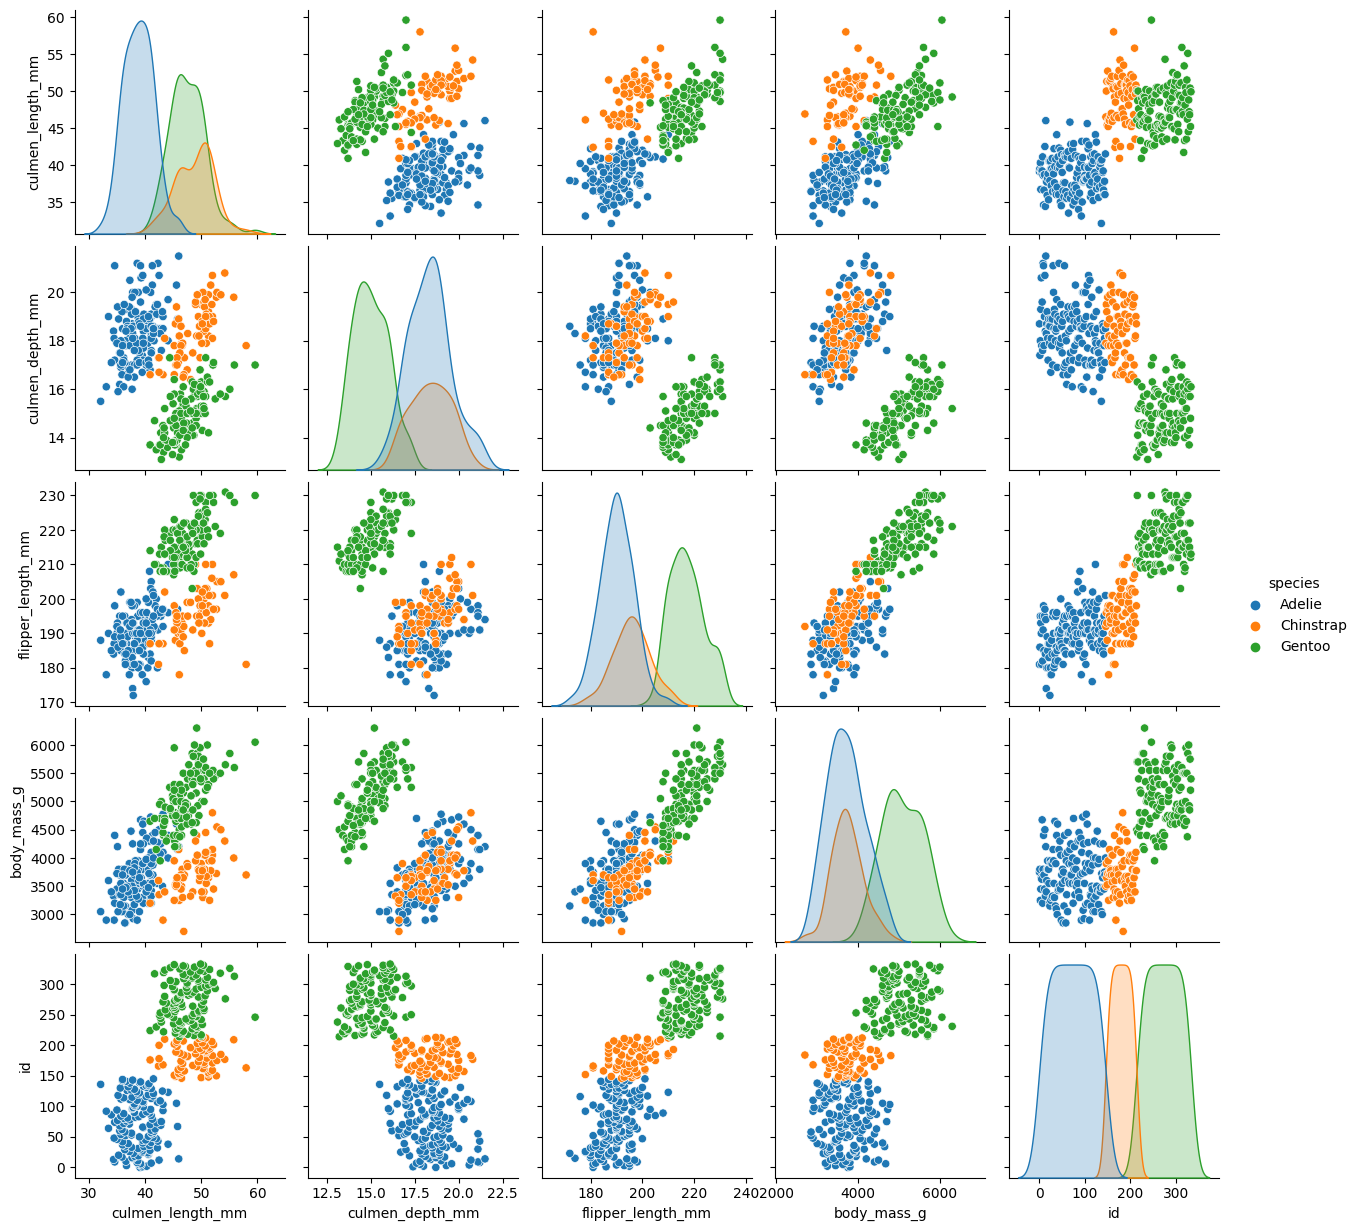

In [6]:
dataset.stat(target_column)

Создаём объект для решения задачи и ищем решающую функцию

In [7]:
analyzer = Analyzer(sklearn.linear_model.LogisticRegression())
analyzer.train(dataset.dataset[['flipper_length_mm','culmen_depth_mm']].to_numpy(),dataset.dataset[target_column].to_numpy())

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Задание №2. Создаём массив из колонки целевой переменной, переводим классы в численный вид, решаем задачу и вычисляем точность решения.

In [8]:
predicts = analyzer.predict(dataset.dataset[['flipper_length_mm','culmen_depth_mm']].to_numpy())
species = dataset.dataset[target_column].to_numpy().copy()
for i, c in enumerate(np.unique(species)):
    species[species == c] = i

species = species.astype(np.int32)
analyzer.accuracy(predicts, species)

0.8353293413173652

Вычисляем полноту


In [9]:
for i in np.unique(species):
    print(f'{pd.unique(dataset.dataset[target_column])[i]} recall is {analyzer.recall(predicts, species, i)}')

Adelie recall is 0.9246575342465754
Chinstrap recall is 0.35294117647058826
Gentoo recall is 1.0


Вычисляем специфичность

In [10]:
for i in np.unique(species):
    print(f'{pd.unique(dataset.dataset[target_column])[i]} specificity is {analyzer.specificity(predicts, species, i)}')

Adelie specificity is 0.7659574468085106
Chinstrap specificity is 0.9586466165413534
Gentoo specificity is 1.0


Задание №3. Вычисляем roc и pr кривые для каждого класса, вычисляем auc под ними

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


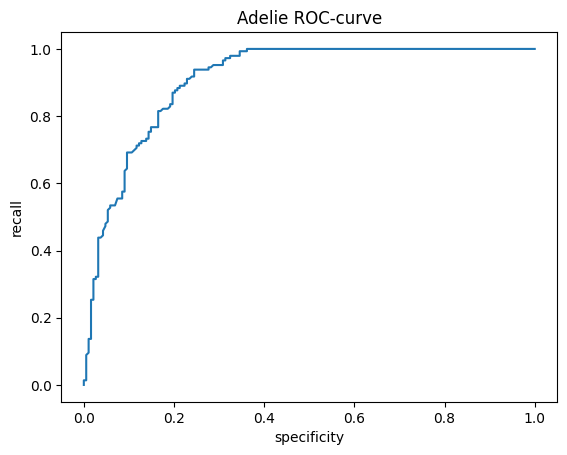

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


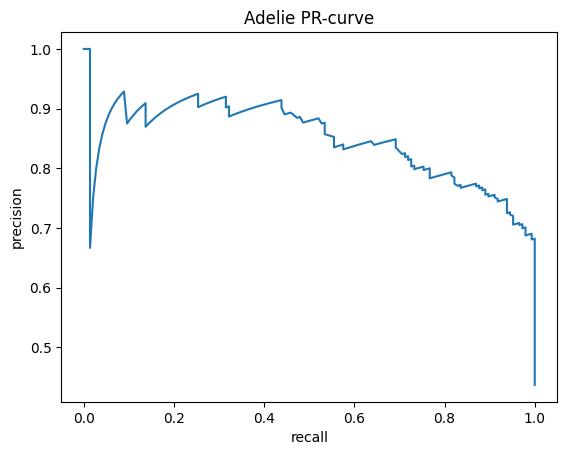

Area-under-curve metrics for Adelie is 0.9096109006120664


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


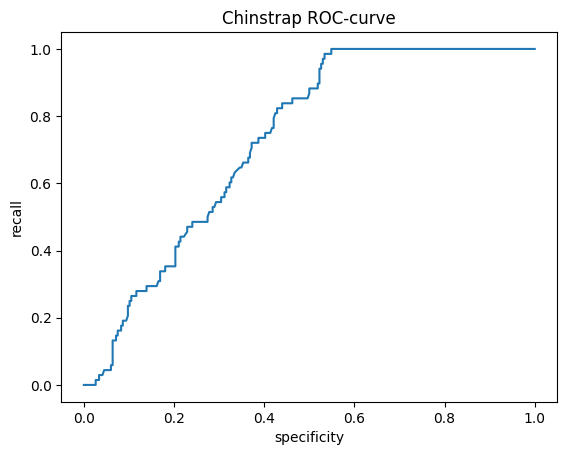

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


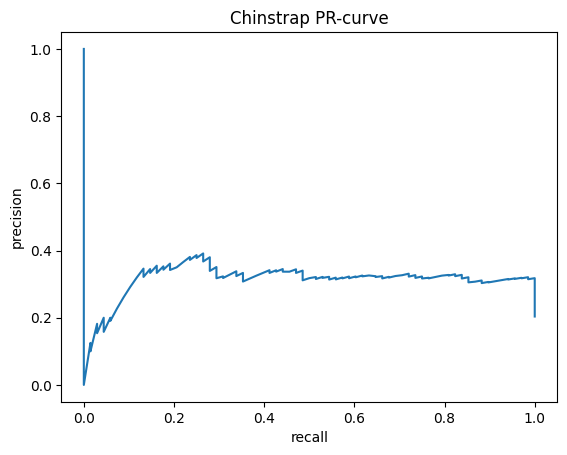

Area-under-curve metrics for Chinstrap is 0.7293785935426803


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


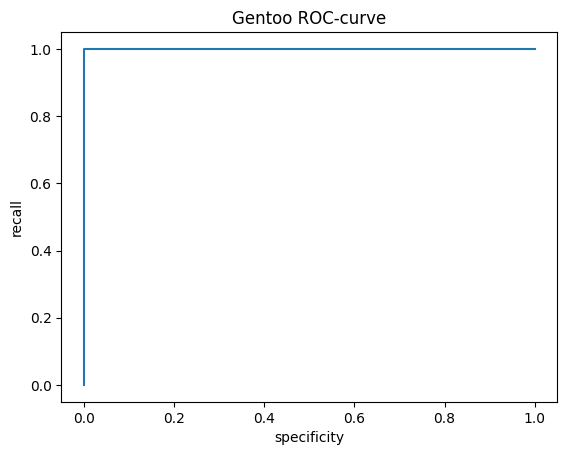

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


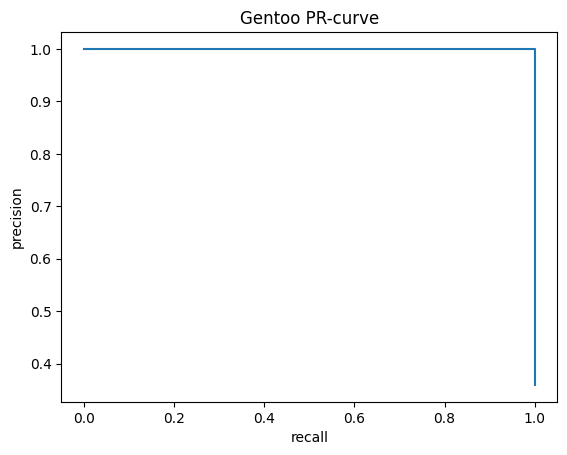

Area-under-curve metrics for Gentoo is 1.0


In [11]:
for i in np.unique(species):
    target_idx = np.where(species == i)
    other_idx = np.where(species != i)

    labels = species.copy()
    labels[target_idx] = 1
    labels[other_idx] = 0

    analyzer.train(dataset.dataset[['flipper_length_mm','culmen_depth_mm']],labels)
    auroc = analyzer.auroc_curve(dataset.dataset[['flipper_length_mm','culmen_depth_mm']].to_numpy(), labels, pd.unique(dataset.dataset[target_column])[i])
    analyzer.pr_curve(dataset.dataset[['flipper_length_mm','culmen_depth_mm']].to_numpy(), labels, pd.unique(dataset.dataset[target_column])[i])
    print(auroc)

Задание №4. Разбиваем выборку на две подвыбоки и строим roc-кривые на их основе

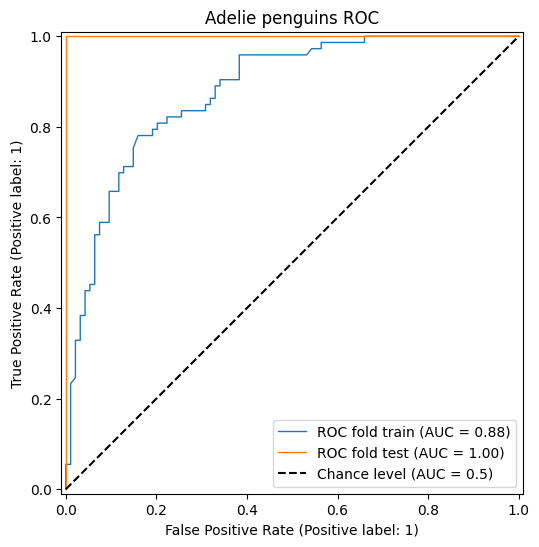

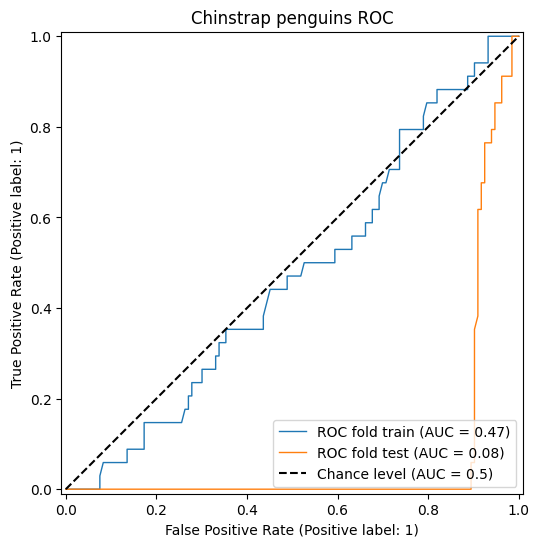

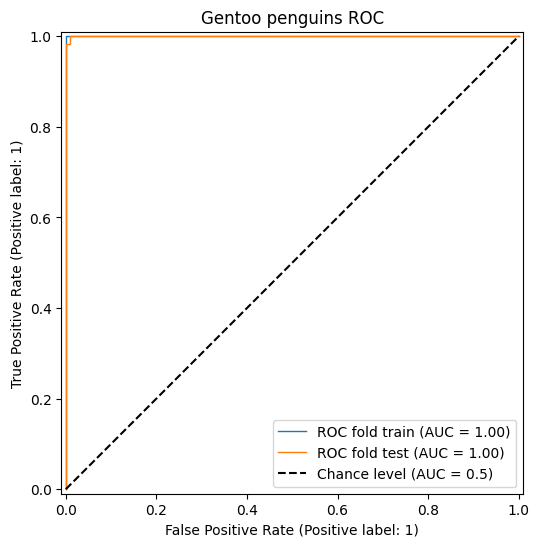

In [12]:
for i in np.unique(species):
    target_idx = np.where(species == i)
    other_idx = np.where(species != i)

    labels = species.copy()
    labels[target_idx] = 1
    labels[other_idx] = 0

    cv = sklearn.model_selection.StratifiedKFold(n_splits=2)
    fig, ax = plt.subplots(figsize=(6, 6))
    mode = ('train','test')
    for fold, (train, test) in enumerate(cv.split(dataset.dataset[['flipper_length_mm','culmen_depth_mm']],labels)):
        analyzer.train(dataset.dataset[['flipper_length_mm','culmen_depth_mm']].to_numpy()[train],labels[train])
        viz = sklearn.metrics.RocCurveDisplay.from_estimator(
            analyzer.train_method,
            dataset.dataset[['flipper_length_mm','culmen_depth_mm']].to_numpy()[test],
            labels[test],
            name=f"ROC fold {mode[fold]}",
            #alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == 1),
        )
        plt.title(f'{pd.unique(dataset.dataset["species"])[i]} penguins ROC')
        # print(fold)
        # print(dataset.dataset[['flipper_length_mm','culmen_depth_mm']].to_numpy()[test])
        # print(species[test])

Исследование влияния метрики на AUC

Классификация адабустом


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this 

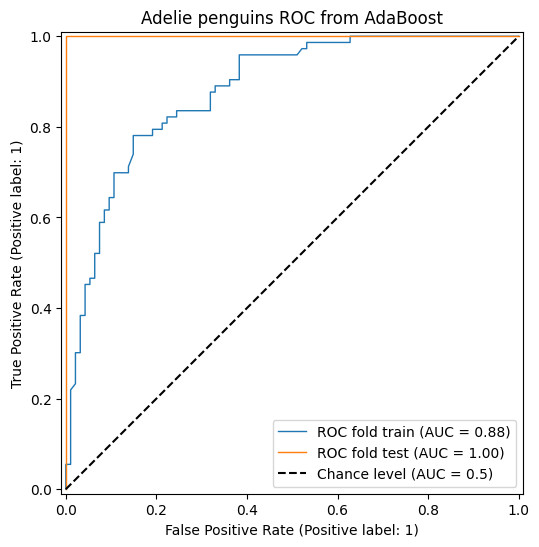

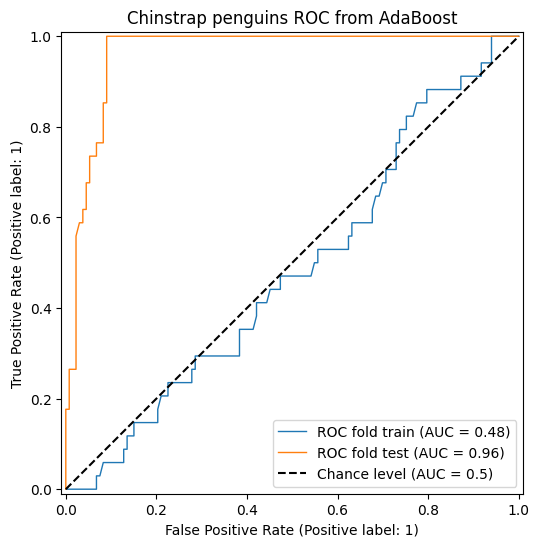

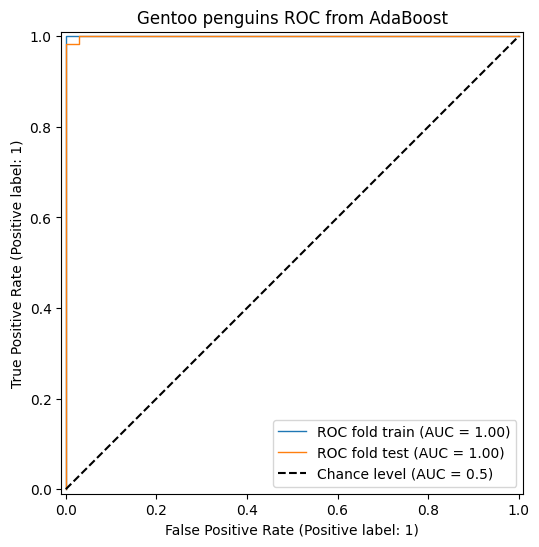

In [13]:
for i in np.unique(species):
    cv = sklearn.model_selection.StratifiedKFold(n_splits=2)
    mode = ('train','test')

    adaboost = sklearn.ensemble.AdaBoostClassifier(estimator=analyzer.train_method)
    target_idx = np.where(species == i)
    other_idx = np.where(species != i)

    labels = species.copy()

    labels[target_idx] = 1
    labels[other_idx] = 0

    adaboost.fit(dataset.dataset[['flipper_length_mm','culmen_depth_mm']].to_numpy(),labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(dataset.dataset[['flipper_length_mm','culmen_depth_mm']].to_numpy(),labels)):
        viz = sklearn.metrics.RocCurveDisplay.from_estimator(
                adaboost,
                dataset.dataset[['flipper_length_mm','culmen_depth_mm']].to_numpy()[test],
                labels[test],
                name=f"ROC fold {mode[fold]}",
                #alpha=0.3,
                lw=1,
                ax=ax,
                plot_chance_level=(fold == 1),
            )
        plt.title(f'{pd.unique(dataset.dataset["species"])[i]} penguins ROC from AdaBoost')

Классификация градиентным бустингом

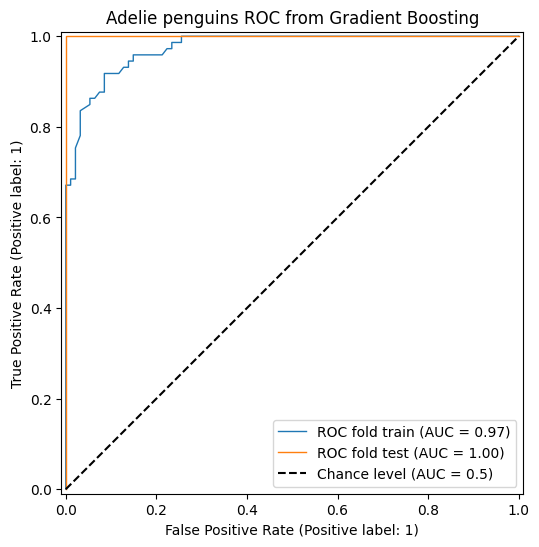

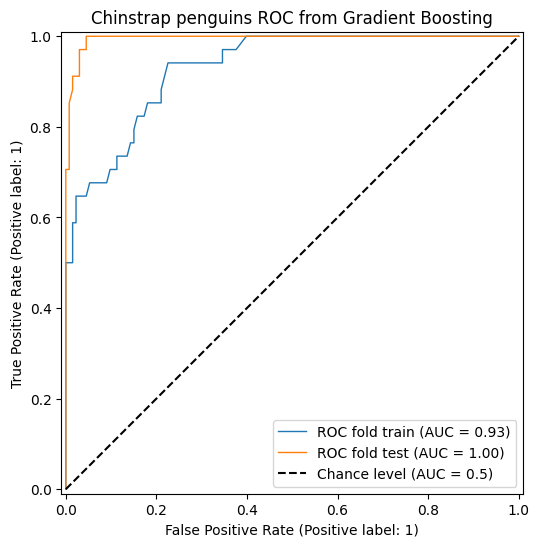

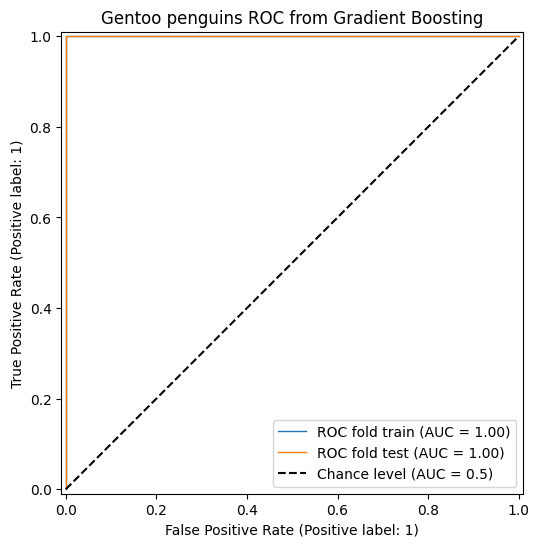

In [14]:
for i in np.unique(species):
    cv = sklearn.model_selection.StratifiedKFold(n_splits=2)
    mode = ('train','test')

    #adaboost = sklearn.ensemble.GradientBoostingClassifier(estimator=analyzer.train_method)
    gradboost = sklearn.ensemble.GradientBoostingClassifier()
    target_idx = np.where(species == i)
    other_idx = np.where(species != i)

    labels = species.copy()

    labels[target_idx] = 1
    labels[other_idx] = 0

    gradboost.fit(dataset.dataset[['flipper_length_mm','culmen_depth_mm']].to_numpy(),labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(dataset.dataset[['flipper_length_mm','culmen_depth_mm']].to_numpy(),labels)):
        viz = sklearn.metrics.RocCurveDisplay.from_estimator(
                gradboost,
                dataset.dataset[['flipper_length_mm','culmen_depth_mm']].to_numpy()[test],
                labels[test],
                name=f"ROC fold {mode[fold]}",
                #alpha=0.3,
                lw=1,
                ax=ax,
                plot_chance_level=(fold == 1),
            )
        plt.title(f'{pd.unique(dataset.dataset["species"])[i]} penguins ROC from Gradient Boosting')

In [33]:
train, test = cv.split(dataset.dataset[['flipper_length_mm','culmen_depth_mm']].to_numpy(),labels)

dataset.dataset.iloc[train[0]].groupby('species').count()

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,id
species,,,,,,,
Adelie,39,39,39,39,39,39,39
Chinstrap,68,68,68,68,68,68,68
Gentoo,60,60,60,60,60,60,60


In [34]:
dataset.dataset.iloc[train[1]].groupby('species').count()

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,id
species,,,,,,,
Adelie,107,107,107,107,107,107,107
Gentoo,60,60,60,60,60,60,60


In [35]:
dataset.dataset.iloc[test[0]].groupby('species').count()

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,id
species,,,,,,,
Adelie,107,107,107,107,107,107,107
Gentoo,60,60,60,60,60,60,60


In [36]:
dataset.dataset.iloc[test[1]].groupby('species').count()

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,id
species,,,,,,,
Adelie,39,39,39,39,39,39,39
Chinstrap,68,68,68,68,68,68,68
Gentoo,60,60,60,60,60,60,60
